In [1]:
import pandas as pd
from utils import *
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split, KFold, cross_val_score, LeaveOneOut
from sklearn.metrics import classification_report
from sklearn.utils import resample

## Load Data

Load all the classes into different Dataframes

In [2]:
class1 = pd.read_csv('data/Data_Class_1.csv')
class3 = pd.read_csv('data/Data_Class_3.csv')
class6 = pd.read_csv('data/Data_Class_6.csv')

## Descriptive Statistics

Combine all classes into one dataset and view the top rows

In [3]:
data = pd.concat([class1, class3, class6], ignore_index=True)
data

,Id,Altitude,Slope_Orientation,Slope,Horizontal_Distance_To_Water,Vertical_Distance_To_Water,Horizontal_Distance_To_Roadways,Shadow_Index_9h,Shadow_Index_12h,Shadow_Index_15h,Horizontal_Distance_To_Fire_Points,Canopy_Density,Rainfall_Summer,Rainfall_Winter,Wind_Exposure_Level,Soil_Type,Wilderness_Area,Vegetation_Type
0,41,2699,347,3,0,0,2096,213,234,159,6853,37.32,282.46,125.22,6.23,Type_20,Area_1,Type_1
1,52,2739,323,25,85,43,3118,149,205,192,6219,76.51,182.57,532.19,30.65,Type_29,Area_1,Type_1
2,53,2696,72,2,30,0,3271,222,234,149,6071,86.37,374.79,275.52,59.96,Type_30,Area_1,Type_1
3,56,2722,315,24,30,19,3216,148,212,200,6132,85.31,364.30,1182.48,22.21,Type_16,Area_1,Type_1
4,68,2919,13,13,90,6,5321,207,214,142,4060,78.13,303.26,1198.69,14.22,Type_29,Area_1,Type_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5935,15106,2480,10,21,150,38,607,193,194,133,1436,82.97,247.13,190.52,45.88,Type_10,Area_3,Type_6
5936,15110,2600,57,19,0,0,731,229,197,93,1332,38.82,163.93,853.03,34.03,Type_10,Area_3,Type_6
5937,15111,2508,33,26,67,1,644,204,173,91,1385,75.93,366.25,442.88,6.98,Type_10,Area_3,Type_6
5938,15112,2610,59,17,60,10,674,231,202,98,1328,74.65,312.00,651.50,55.74,Type_10,Area_3,Type_6


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5940 entries, 0 to 5939
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Id                                  5940 non-null   int64  
 1   Altitude                            5940 non-null   int64  
 2   Slope_Orientation                   5940 non-null   int64  
 3   Slope                               5940 non-null   int64  
 4   Horizontal_Distance_To_Water        5940 non-null   int64  
 5   Vertical_Distance_To_Water          5940 non-null   int64  
 6   Horizontal_Distance_To_Roadways     5940 non-null   int64  
 7   Shadow_Index_9h                     5940 non-null   int64  
 8   Shadow_Index_12h                    5940 non-null   int64  
 9   Shadow_Index_15h                    5940 non-null   int64  
 10  Horizontal_Distance_To_Fire_Points  5940 non-null   int64  
 11  Canopy_Density                      5940 no

According to this information:
- 5940 rows
- 18 columns
- No null values
- 3 categorical columns and 15 numerical columns

#### Numerical Columns

View some metrics of each numerical column

In [5]:
data.describe()

,Id,Altitude,Slope_Orientation,Slope,Horizontal_Distance_To_Water,Vertical_Distance_To_Water,Horizontal_Distance_To_Roadways,Shadow_Index_9h,Shadow_Index_12h,Shadow_Index_15h,Horizontal_Distance_To_Fire_Points,Canopy_Density,Rainfall_Summer,Rainfall_Winter,Wind_Exposure_Level
count,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000
mean,8038.627946,2672.851684,171.001347,17.276263,214.397475,48.701347,1588.265488,202.461448,216.604882,144.623232,1360.505387,60.077453,300.091620,647.547544,35.107199
std,4201.653201,387.964294,121.193059,8.397512,176.610733,54.068275,1265.901292,33.925223,23.720654,44.343675,998.115844,17.404128,86.575054,323.281830,17.442532
min,41.000000,1863.000000,0.000000,1.000000,0.000000,-104.000000,0.000000,0.000000,120.000000,0.000000,0.000000,30.000000,150.030000,90.070000,5.000000
25%,4926.250000,2378.000000,55.000000,11.000000,85.000000,8.000000,695.250000,182.000000,204.000000,115.000000,674.000000,44.910000,225.855000,363.685000,20.010000
50%,8070.000000,2572.000000,145.000000,16.000000,180.000000,34.000000,1230.000000,209.000000,220.000000,145.000000,1095.000000,60.190000,301.910000,650.650000,35.215000
75%,11311.250000,3062.000000,302.000000,23.000000,306.000000,75.000000,2072.000000,229.000000,234.000000,177.250000,1785.000000,75.147500,373.827500,930.800000,50.205000
max,15118.000000,3675.000000,360.000000,52.000000,1129.000000,411.000000,6508.000000,254.000000,254.000000,248.000000,6993.000000,89.990000,449.970000,1199.880000,64.990000


#### Categorical columns

View some metrics of each categorical column

In [6]:
data.describe(include='object')

,Soil_Type,Wilderness_Area,Vegetation_Type
count,5940,5940,5940
unique,32,4,3
top,Type_10,Area_3,Type_1
freq,1634,2529,2160


## Univariate Analysis

In [7]:
numerical_columns = data.select_dtypes(exclude='object').columns.drop('Id')
categorical_columns = data.select_dtypes(include='object').columns

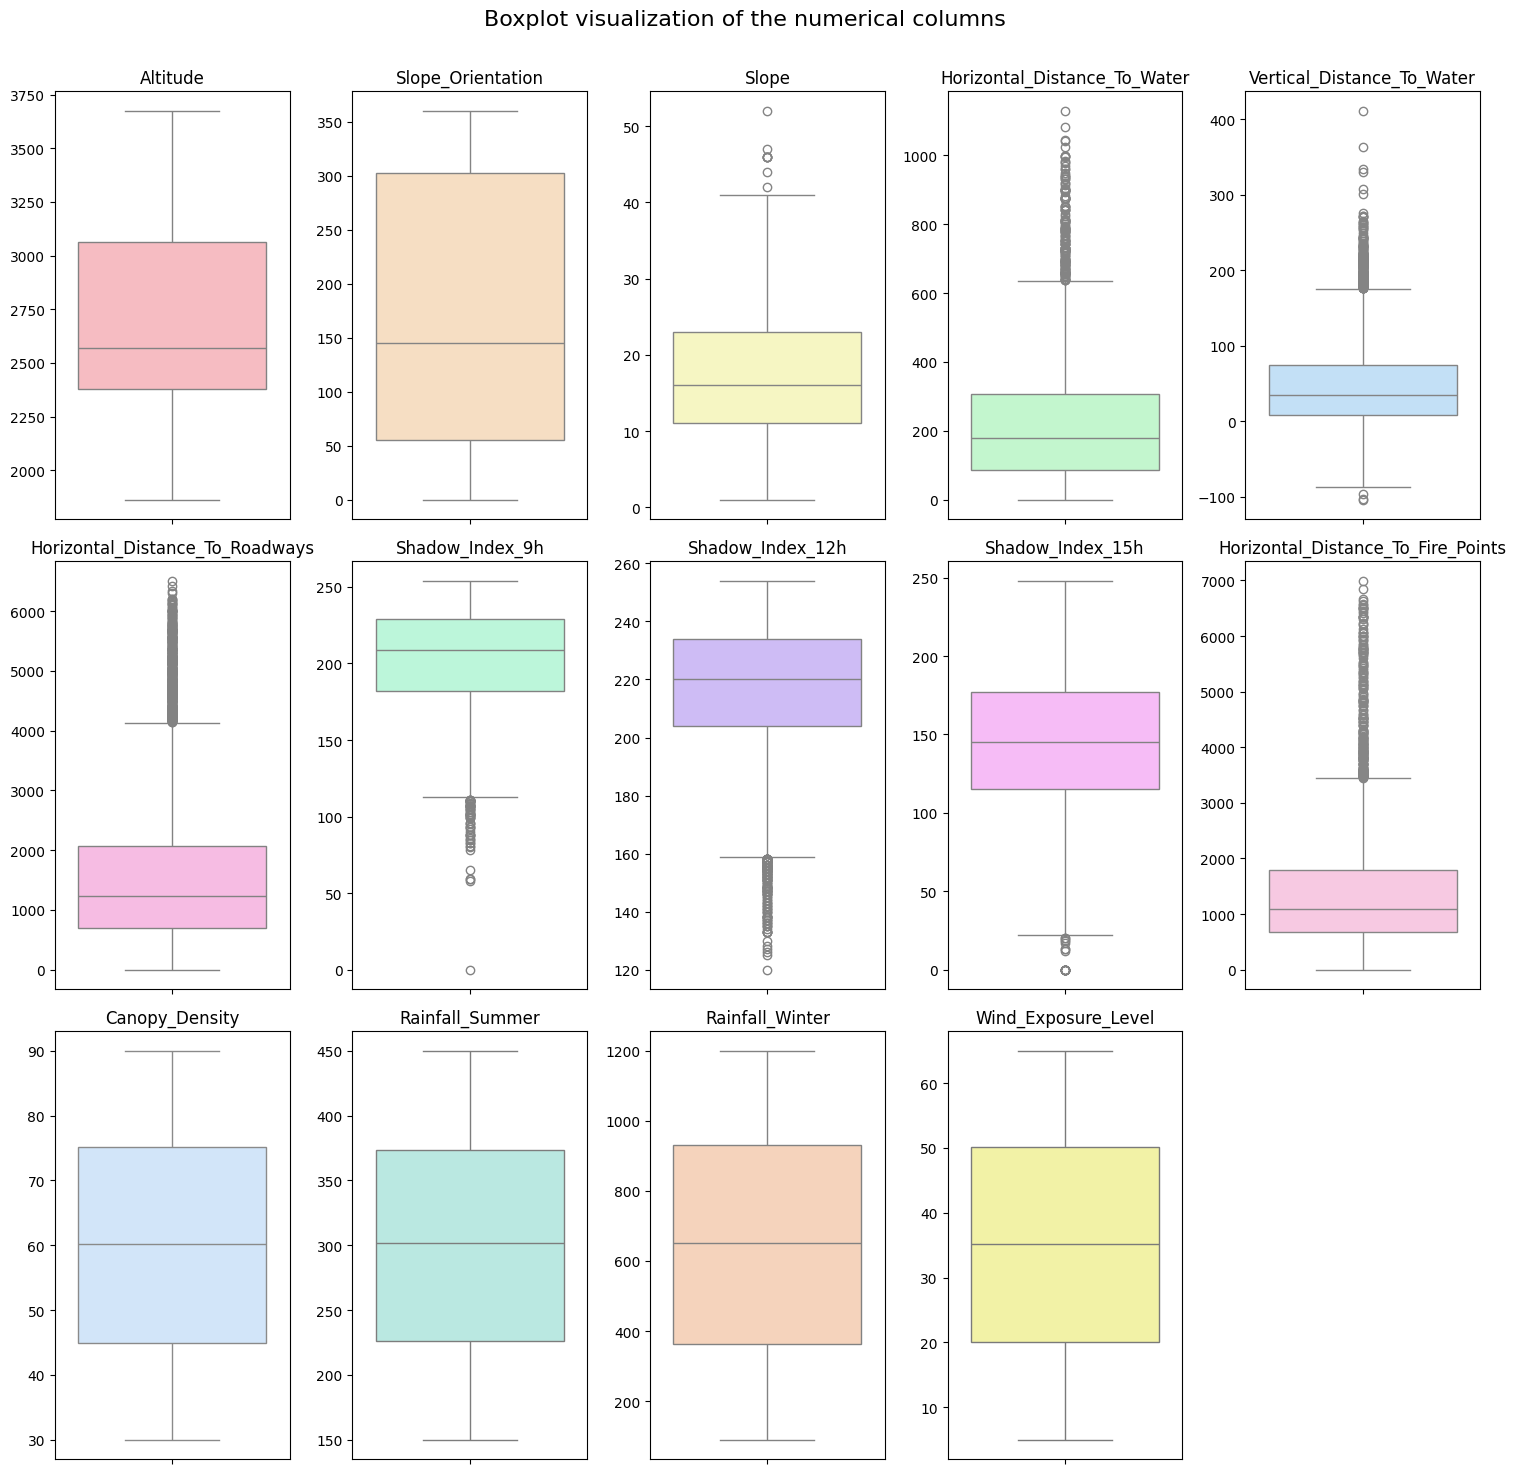

In [8]:
boxplot_visualization(data, numerical_columns, 'Boxplot visualization of the numerical columns')

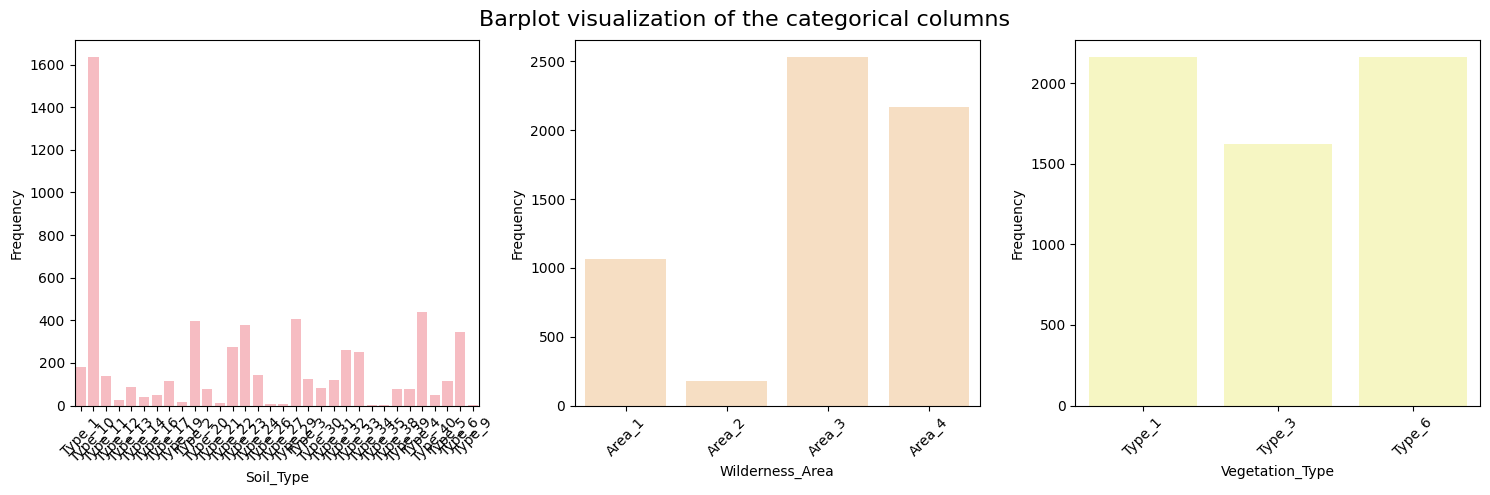

In [9]:
barplot_visualization(data, categorical_columns, 'Barplot visualization of the categorical columns')

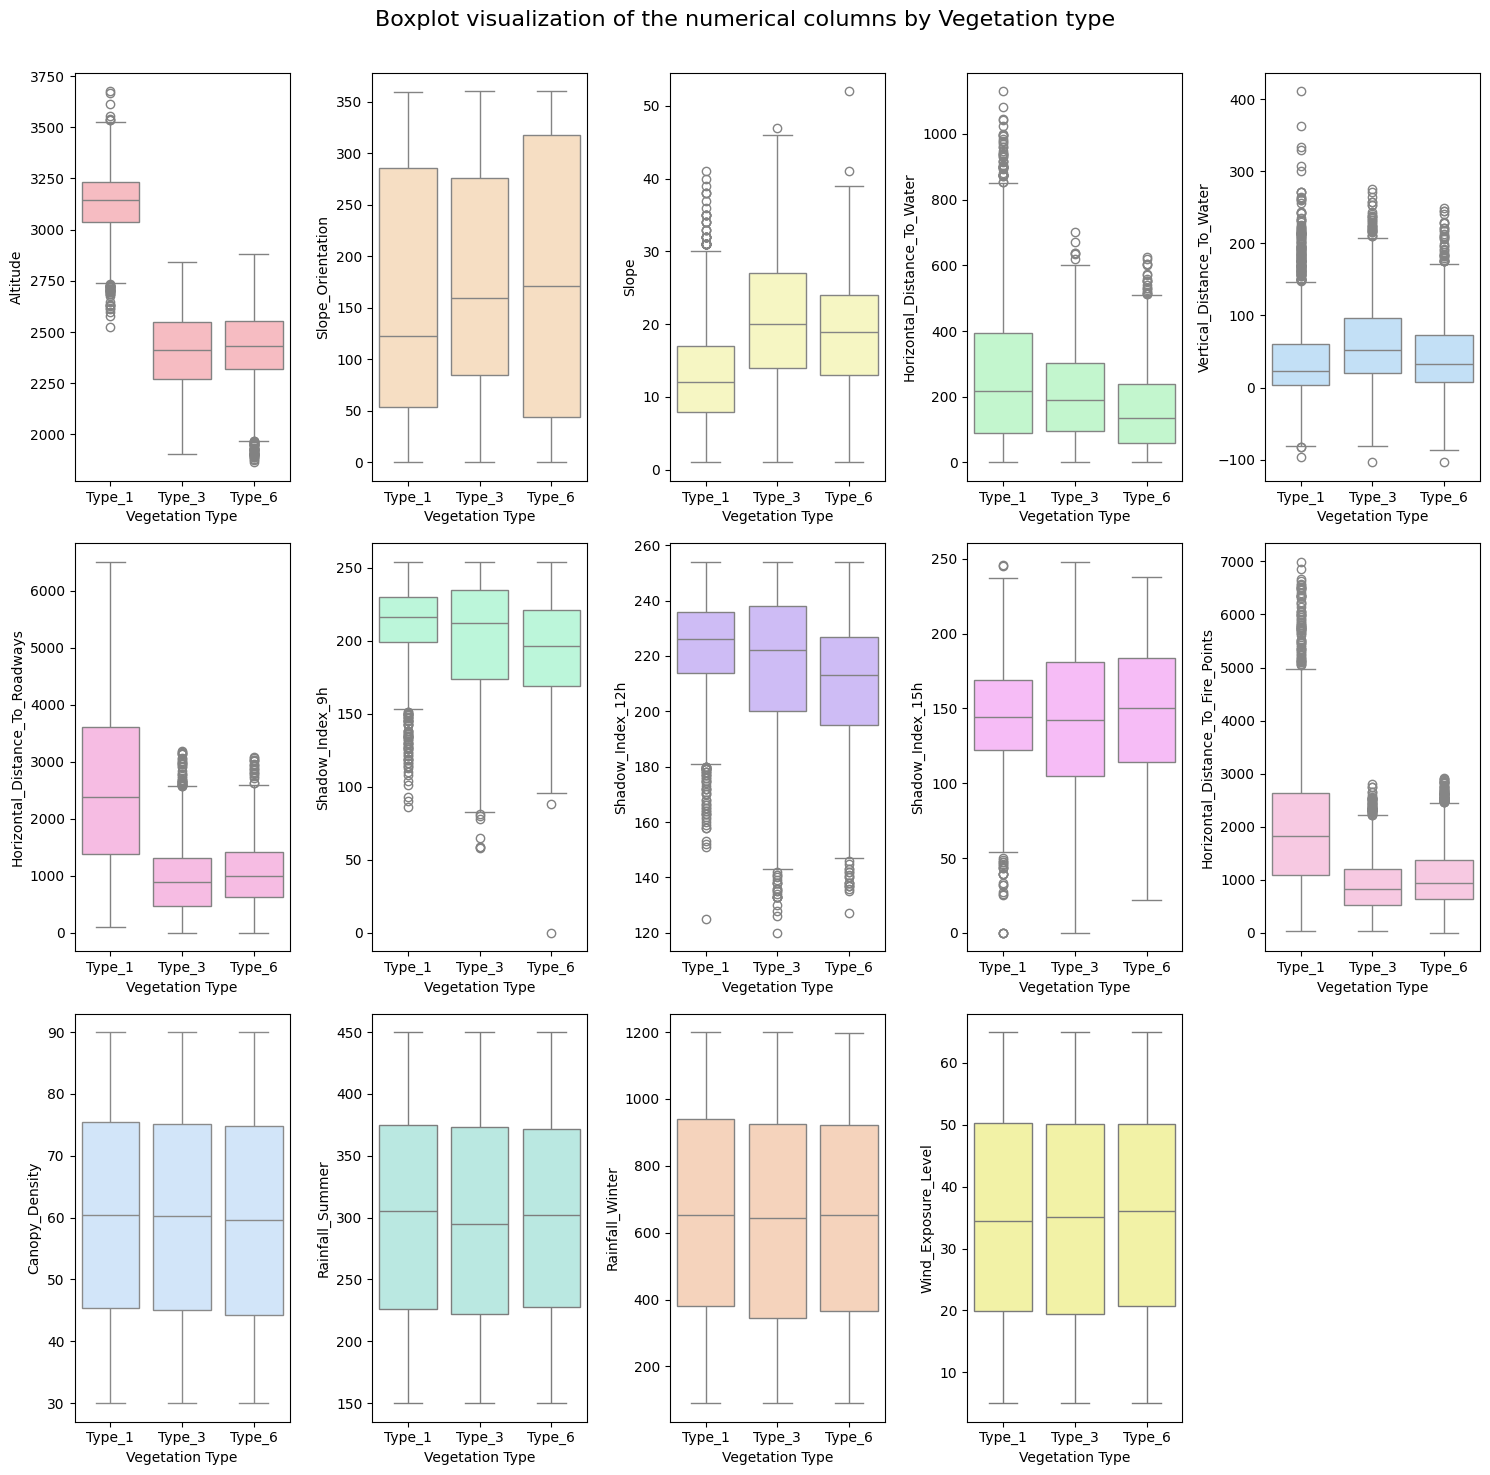

In [10]:
boxplot_by_type_visualization(data, numerical_columns, 'Boxplot visualization of the numerical columns by Vegetation type')

## Bivariate Analysis

In [11]:
encoded_data = data.copy()
encoded_data['Soil_Type_Enc'] = pd.factorize(data['Soil_Type'])[0]
encoded_data['Wilderness_Area_Enc'] = pd.factorize(data['Wilderness_Area'])[0]
encoded_data['Vegetation_Type_Enc'] = pd.factorize(data['Vegetation_Type'])[0]

In [12]:
encoded_data.describe()

,Id,Altitude,Slope_Orientation,Slope,Horizontal_Distance_To_Water,Vertical_Distance_To_Water,Horizontal_Distance_To_Roadways,Shadow_Index_9h,Shadow_Index_12h,Shadow_Index_15h,Horizontal_Distance_To_Fire_Points,Canopy_Density,Rainfall_Summer,Rainfall_Winter,Wind_Exposure_Level,Soil_Type_Enc,Wilderness_Area_Enc,Vegetation_Type_Enc
count,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000
mean,8038.627946,2672.851684,171.001347,17.276263,214.397475,48.701347,1588.265488,202.461448,216.604882,144.623232,1360.505387,60.077453,300.091620,647.547544,35.107199,15.752862,1.581650,1.000000
std,4201.653201,387.964294,121.193059,8.397512,176.610733,54.068275,1265.901292,33.925223,23.720654,44.343675,998.115844,17.404128,86.575054,323.281830,17.442532,8.008764,1.153733,0.852875
min,41.000000,1863.000000,0.000000,1.000000,0.000000,-104.000000,0.000000,0.000000,120.000000,0.000000,0.000000,30.000000,150.030000,90.070000,5.000000,0.000000,0.000000,0.000000
25%,4926.250000,2378.000000,55.000000,11.000000,85.000000,8.000000,695.250000,182.000000,204.000000,115.000000,674.000000,44.910000,225.855000,363.685000,20.010000,10.000000,1.000000,0.000000
50%,8070.000000,2572.000000,145.000000,16.000000,180.000000,34.000000,1230.000000,209.000000,220.000000,145.000000,1095.000000,60.190000,301.910000,650.650000,35.215000,18.000000,1.000000,1.000000
75%,11311.250000,3062.000000,302.000000,23.000000,306.000000,75.000000,2072.000000,229.000000,234.000000,177.250000,1785.000000,75.147500,373.827500,930.800000,50.205000,18.000000,3.000000,2.000000
max,15118.000000,3675.000000,360.000000,52.000000,1129.000000,411.000000,6508.000000,254.000000,254.000000,248.000000,6993.000000,89.990000,449.970000,1199.880000,64.990000,31.000000,3.000000,2.000000


<Axes: >

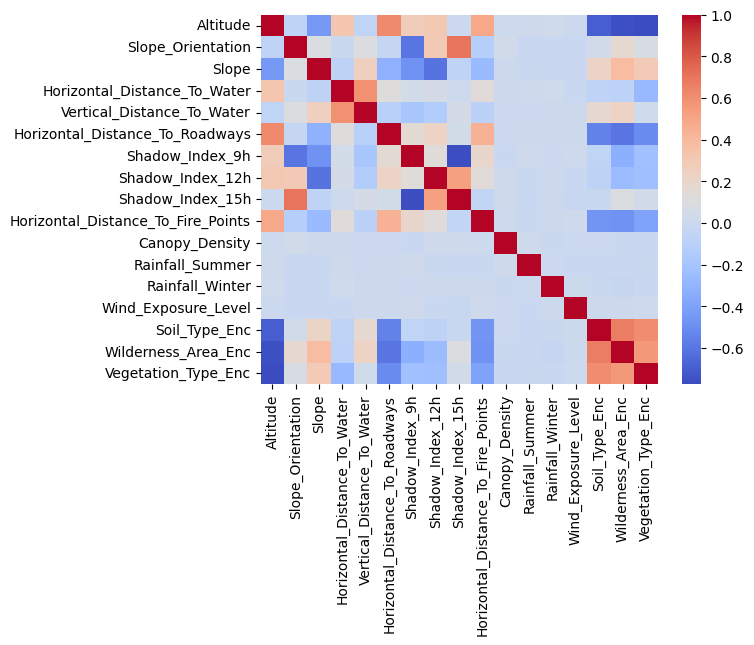

In [13]:
# Remove Id for correlation matrix
encoded_data_without_id = encoded_data.drop('Id', axis=1)

sns.heatmap(encoded_data_without_id.corr(numeric_only=True), cmap="coolwarm" )

In the next step, the columns with close to 0 correlation with any other columns will be deleted, seeing as these do not provide any benefit to our analysis.

The following columns will be removed:
- Canopy_Density
- Rainfall_Summer
- Rainfall_Winter
- Wind_Exposure_Level

In [14]:
# Removing the columns without any correlation
encoded_data_without_id = encoded_data_without_id.drop(['Canopy_Density', 'Rainfall_Summer', 'Rainfall_Winter', 'Wind_Exposure_Level'], axis=1)

<Axes: >

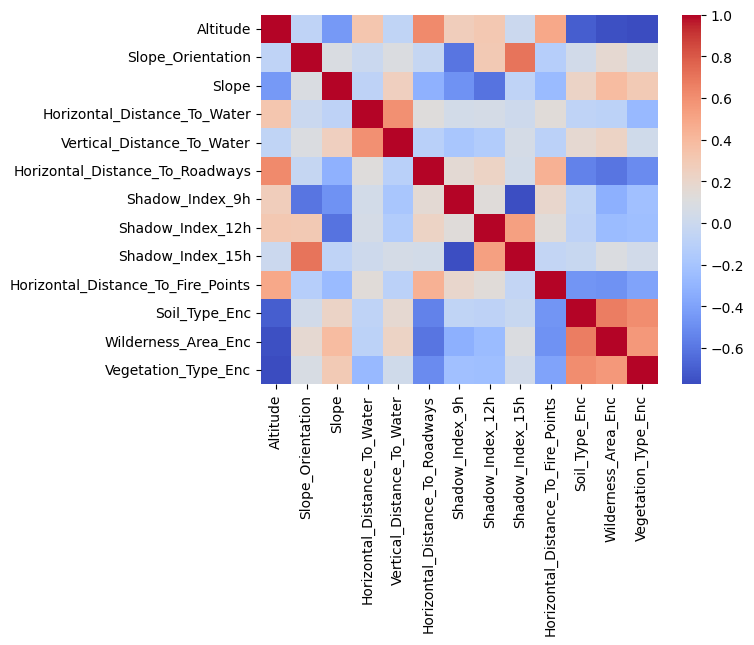

In [15]:
corr_matrix = encoded_data_without_id.corr(numeric_only=True)

sns.heatmap(corr_matrix, cmap="coolwarm")

In [16]:
corr_matrix

,Altitude,Slope_Orientation,Slope,Horizontal_Distance_To_Water,Vertical_Distance_To_Water,Horizontal_Distance_To_Roadways,Shadow_Index_9h,Shadow_Index_12h,Shadow_Index_15h,Horizontal_Distance_To_Fire_Points,Soil_Type_Enc,Wilderness_Area_Enc,Vegetation_Type_Enc
Altitude,1.000000,-0.073906,-0.445400,0.320920,-0.061765,0.620801,0.268285,0.309296,0.000590,0.493605,-0.699724,-0.759792,-0.774637
Slope_Orientation,-0.073906,1.000000,0.091453,-0.006280,0.093974,-0.037092,-0.605879,0.301922,0.704323,-0.117486,0.035943,0.173883,0.074433
Slope,-0.445400,0.091453,1.000000,-0.081415,0.255881,-0.322957,-0.480340,-0.612619,-0.073909,-0.263317,0.222414,0.387427,0.298247
Horizontal_Distance_To_Water,0.320920,-0.006280,-0.081415,1.000000,0.595274,0.120164,0.037495,0.055733,0.011886,0.135802,-0.068218,-0.083824,-0.269011
Vertical_Distance_To_Water,-0.061765,0.093974,0.255881,0.595274,1.000000,-0.105307,-0.189484,-0.138105,0.053614,-0.095020,0.168866,0.224435,0.028331
Horizontal_Distance_To_Roadways,0.620801,-0.037092,-0.322957,0.120164,-0.105307,1.000000,0.154439,0.227023,0.036593,0.444786,-0.546106,-0.605209,-0.510261
Shadow_Index_9h,0.268285,-0.605879,-0.480340,0.037495,-0.189484,0.154439,1.000000,0.129316,-0.762588,0.189466,-0.065123,-0.326906,-0.227859
Shadow_Index_12h,0.309296,0.301922,-0.612619,0.055733,-0.138105,0.227023,0.129316,1.000000,0.525597,0.133809,-0.078419,-0.257865,-0.238884
Shadow_Index_15h,0.000590,0.704323,-0.073909,0.011886,0.053614,0.036593,-0.762588,0.525597,1.000000,-0.053656,-0.024120,0.095153,0.034780
Horizontal_Distance_To_Fire_Points,0.493605,-0.117486,-0.263317,0.135802,-0.095020,0.444786,0.189466,0.133809,-0.053656,1.000000,-0.466654,-0.483002,-0.400223


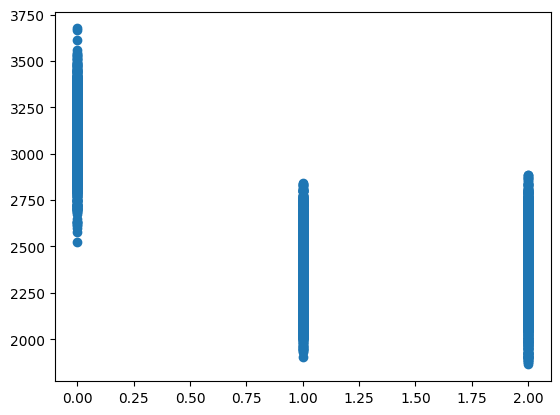

In [17]:
plt.scatter(y=encoded_data['Altitude'], x=encoded_data['Vegetation_Type_Enc'])

<Axes: xlabel='Soil_Type'>

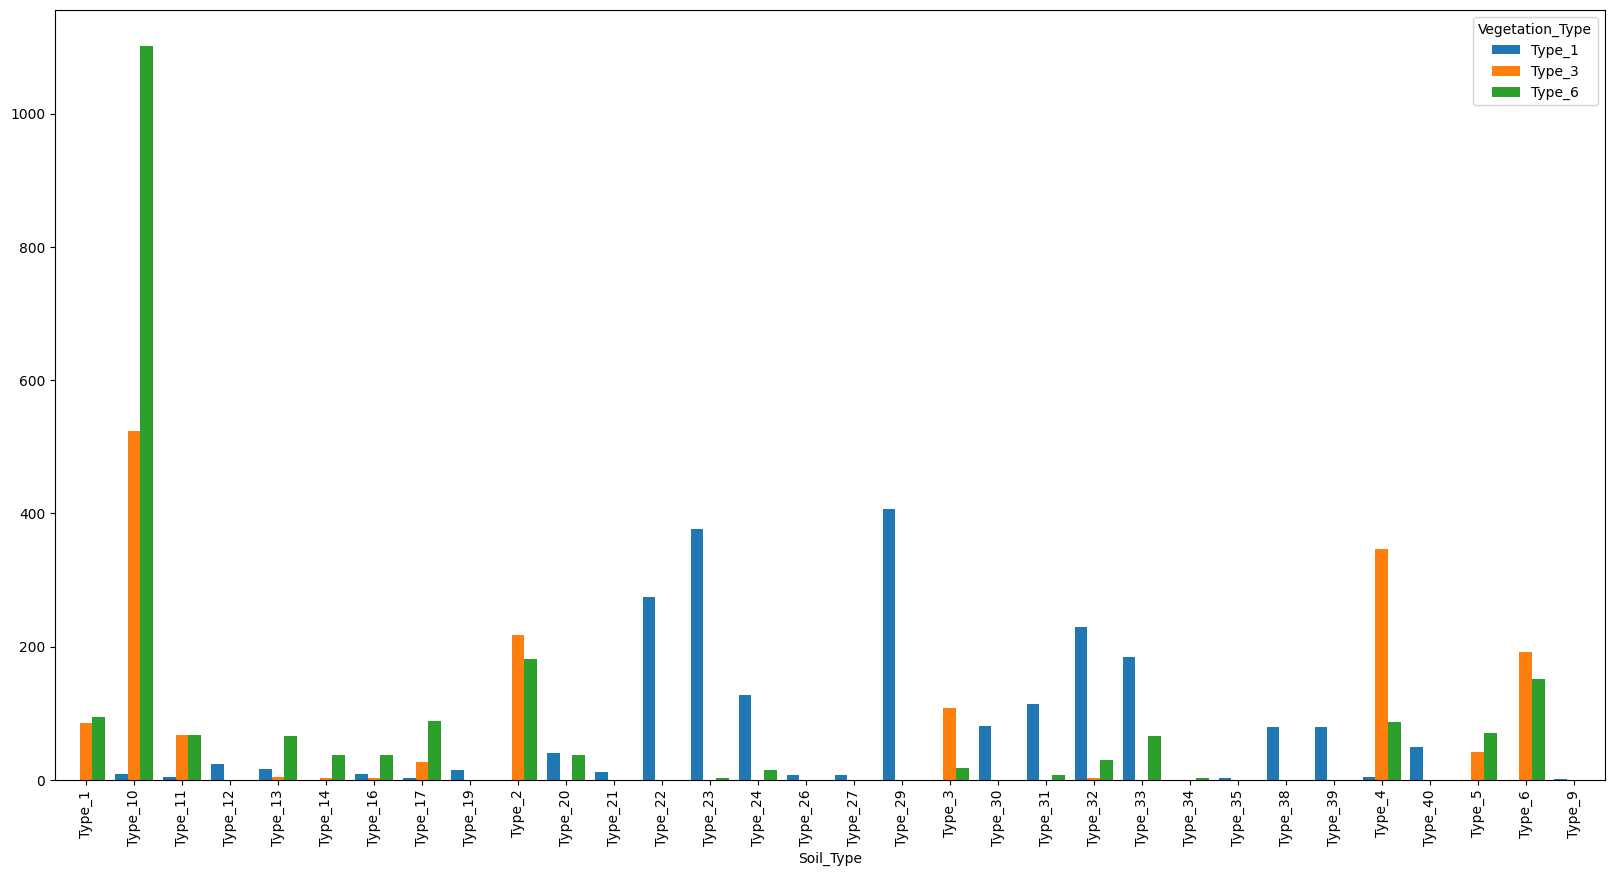

In [18]:
pd.crosstab(data['Soil_Type'], data['Vegetation_Type']).plot(kind='bar', figsize=(20, 10), width=0.8)

<Axes: xlabel='Wilderness_Area'>

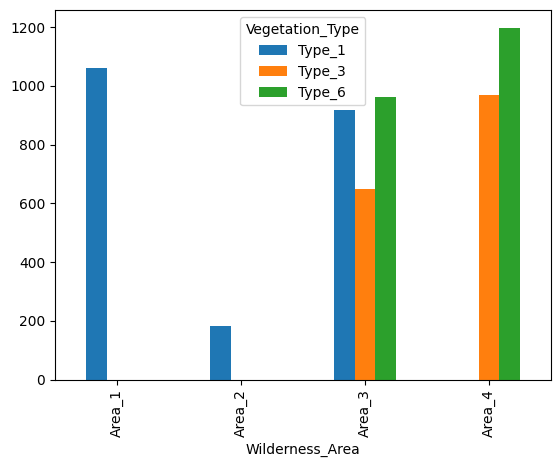

In [19]:
pd.crosstab(data['Wilderness_Area'], data['Vegetation_Type']).plot(kind='bar')

# Methods Application

Load the models:

In [20]:
models = {
    'Logistic Regression': LogisticRegression(),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis()
}

metrics = ['accuracy', 'precision', 'recall', 'f1']

Data Preparation

In [ ]:
X = encoded_data.drop(columns=['Vegetation_Type', 'Soil_Type', 'Wilderness_Area'])
y = encoded_data['Vegetation_Type_Enc']

# Holdout Method

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    accuracy = report['accuracy']
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision (weighted avg): {precision:.3f}")
    print(f"Recall (weighted avg): {recall:.3f}")
    print(f"F1 Score (weighted avg): {f1:.3f}")
    print("-------------------------------------------------")

Model: Logistic Regression
Accuracy: 0.646
Precision (weighted avg): 0.650
Recall (weighted avg): 0.646
F1 Score (weighted avg): 0.617
-------------------------------------------------
Model: LDA
Accuracy: 0.791
Precision (weighted avg): 0.794
Recall (weighted avg): 0.791
F1 Score (weighted avg): 0.786
-------------------------------------------------
Model: QDA
Accuracy: 0.383
Precision (weighted avg): 0.147
Recall (weighted avg): 0.383
F1 Score (weighted avg): 0.212
-------------------------------------------------


C:\Users\alexa\anaconda3\envs\APRAU_projeto\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\alexa\anaconda3\envs\APRAU_projeto\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\alexa\anaconda3\envs\APRAU_projeto\Lib\site-packages\sklearn\discriminant_analysis.py:972: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\alexa\anaconda3\envs\APRAU_projeto\Lib\site-packages\sklearn\discriminant_analysis.py:972

# Cross Validation (K=5 and K=10)

In [22]:
kf5 = KFold(n_splits=5)
kf10 = KFold(n_splits=10)

for name,model in models.items():
    scores_kf5 = cross_val_score(model, X, y, cv=kf5, scoring='accuracy', n_jobs=-1)
    scores_kf10 = cross_val_score(model, X, y, cv=kf10, scoring='accuracy', n_jobs=-1)
    print(f"Model: {name}")
    print(f"Mean Accuracy with kf5: {np.mean(scores_kf5):.3f}")
    print(f"Standard Deviation with kf5: {np.std(scores_kf5):.3f}")
    print(f"Mean Accuracy with kf10: {np.mean(scores_kf10):.3f}")
    print(f"Standard Deviation with kf10: {np.std(scores_kf10):.3f}")
    print("-------------------------------------------------")

Model: Logistic Regression
Mean Accuracy with kf5: 0.249
Standard Deviation with kf5: 0.259
Mean Accuracy with kf5: 0.418
Standard Deviation with kf5: 0.303
-------------------------------------------------
Model: LDA
Mean Accuracy with kf5: 0.450
Standard Deviation with kf5: 0.366
Mean Accuracy with kf5: 0.618
Standard Deviation with kf5: 0.257
-------------------------------------------------
Model: QDA
Mean Accuracy with kf5: 0.364
Standard Deviation with kf5: 0.449
Mean Accuracy with kf5: 0.364
Standard Deviation with kf5: 0.456
-------------------------------------------------


# Leave One Out Cross Validation (LOOCV)

In [23]:
cv = LeaveOneOut()

for name,model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"Model: {name}")
    print(f"Mean Accuracy: {np.mean(scores):.3f}")
    print(f"Standard Deviation: {np.std(scores):.3f}")
    print("-------------------------------------------------")

Model: Logistic Regression
Mean Accuracy: 0.657
Standard Deviation: 0.475
-------------------------------------------------
Model: LDA
Mean Accuracy: 0.793
Standard Deviation: 0.405
-------------------------------------------------
Model: QDA
Mean Accuracy: 0.364
Standard Deviation: 0.481
-------------------------------------------------


# Bootstrap

In [24]:
n_iterations = 100
bootstrap_scores = {name: [] for name in models.keys()}

for i in range(n_iterations):
    X_resampled, y_resampled = resample(X_train, y_train, n_samples=len(X_train), replace=True)
    
    for name, model in models.items():
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        bootstrap_scores[name].append(report['accuracy'])

for name, scores in bootstrap_scores.items():
    print(f"Model: {name}")
    print(f"Mean Accuracy: {np.mean(scores):.3f}")
    print(f"Standard Deviation: {np.std(scores):.3f}")
    print("-------------------------------------------------")

C:\Users\alexa\anaconda3\envs\APRAU_projeto\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\alexa\anaconda3\envs\APRAU_projeto\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\alexa\anaconda3\envs\APRAU_projeto\Lib\site-packages\sklearn\discriminant_analysis.py:972: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\alexa\anaconda3\envs\APRAU_projeto\Lib\site-packages\sklearn\discriminant_analysis.py:972

Model: Logistic Regression
Mean Accuracy: 0.649
Standard Deviation: 0.012
-------------------------------------------------
Model: LDA
Mean Accuracy: 0.791
Standard Deviation: 0.005
-------------------------------------------------
Model: QDA
Mean Accuracy: 0.383
Standard Deviation: 0.000
-------------------------------------------------


C:\Users\alexa\anaconda3\envs\APRAU_projeto\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\alexa\anaconda3\envs\APRAU_projeto\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\alexa\anaconda3\envs\APRAU_projeto\Lib\site-packages\sklearn\discriminant_analysis.py:972: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\alexa\anaconda3\envs\APRAU_projeto\Lib\site-packages\sklearn\discriminant_analysis.py:972